In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

library(keras)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "alien-vs-predator-images"     "full-keras-pretrained-no-top"

In [2]:
train_datagen<-image_data_generator(rescale=1/255,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   zoom_range=0.5,
                                   fill_mode='nearest')
val_datagen<-image_data_generator(rescale=1/255)

In [3]:
train_dir<-file.path('../input/alien-vs-predator-images/data/train')
val_dir<-file.path('../input/alien-vs-predator-images/data/validation')

In [4]:
train_generator<-flow_images_from_directory(directory=train_dir,
                                           generator=train_datagen,
                                           class_mode='binary',
                                           target_size=c(224,224),
                                           )

val_generator<-flow_images_from_directory(directory=val_dir,
                                           generator=val_datagen,
                                           class_mode='binary',
                                           target_size=c(224,224),
                                           )

In [5]:
conv_base<-application_vgg19(weights='../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                            include_top=FALSE,
                            input_shape=c(224,224,3))
summary(conv_base)
freeze_weights(conv_base)
conv_base %>% unfreeze_weights(from='block5_conv3')

Model: "vgg19"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 224, 224, 3)]           0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 224, 224, 64)            1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 224, 224, 64)            36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 112, 112, 64)            0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 112, 112, 128)           73856       
________________________________________________________________________________
block2_conv2 

In [6]:
model <- keras_model_sequential() %>%
    conv_base %>%
    layer_flatten() %>%
    layer_dense(units=32, activation='relu', kernel_regularizer=regularizer_l2(0.01)) %>%
    layer_dropout(rate=0.3) %>%
    layer_dense(units=1, activation='sigmoid')

model %>% compile(
    metrics=c('accuracy','AUC'),
    loss='binary_crossentropy',
    optimizer=optimizer_adam(lr=1e-4)
)

summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
vgg19 (Functional)                  (None, 7, 7, 512)               20024384    
________________________________________________________________________________
flatten (Flatten)                   (None, 25088)                   0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 32)                      802848      
________________________________________________________________________________
dropout (Dropout)                   (None, 32)                      0           
________________________________________________________________________________
dense (Dense)                       (None, 1)                       33          
Total params: 20,827,265
Trainable params: 5,522,497
Non-trainable params: 15,304,768
___


Final epoch (plot to see history):
        loss: 0.6619
    accuracy: 0.8259
         auc: 0.9181
    val_loss: 0.5244
val_accuracy: 0.9167
     val_auc: 0.9802 

`geom_smooth()` using formula 'y ~ x'



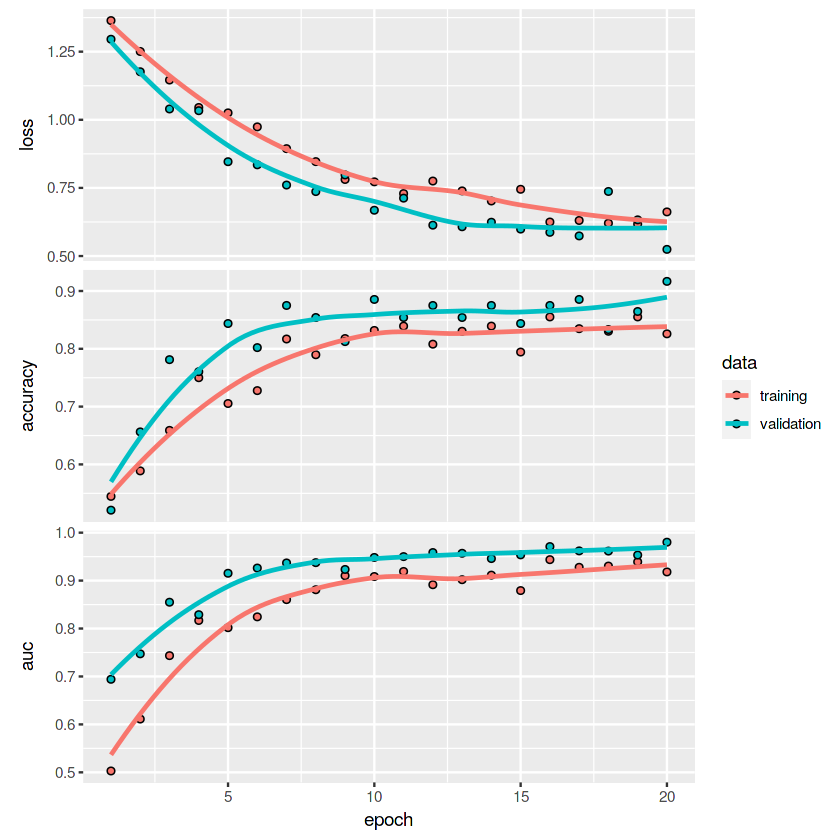

In [7]:
history <- model %>% fit_generator(train_generator,
                                  steps_per_epoch=7,
                                  epochs=20,
                                  validation_data=val_generator,
                                  validation_steps=3)

history;plot(history)
save_model_hdf5(model, 'alien predator model.h5')